In [288]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Reading Data

In [5]:
gdp_df = pd.read_csv('../data/gdp-data/SQGDP2__ALL_AREAS_2005_2021.csv')
vax_df = pd.read_csv('../data/vaccination-data/us_state_vaccinations.csv')

# Processing Vaccination Data

First, I'll aggregate states' vaccination rates per 1000 into quarterly numbers.

In [96]:
def find_quarter(date):
    datetime_object = datetime.strptime(date, '%Y-%m-%d')
    if datetime_object.month <= 3:
        return str(datetime_object.year)+":Q1"
    elif datetime_object.month <= 6:
        return str(datetime_object.year)+":Q2"
    elif datetime_object.month <= 9:
        return str(datetime_object.year)+":Q3"
    else:
        return str(datetime_object.year)+":Q4"

In [149]:
vax_df_quarterly = vax_df.copy()
vax_df_quarterly['quarter'] = vax_df_quarterly['date'].apply(find_quarter)

Cleaning the vaccination data set
* Removing unnecessary data columns
* Finding maxes per quarter (or for daily, aggregating per quarter)
* Removing locations that don't correlate with other data (pretty much restricting to states)
* Drop NA?

In [150]:
vax_df_quarterly = vax_df_quarterly[['quarter', 'location', 'people_fully_vaccinated_per_hundred', 
                                    'total_vaccinations_per_hundred', 'distributed_per_hundred',
                                    'daily_vaccinations_per_million']]

In [151]:
# Note - new york is listed as New York State for some reason, so we need to convert it to make state names match easily
vax_df_quarterly.loc[vax_df_quarterly['location'] == 'New York State', 'location'] = 'New York'

In [153]:
state_names = ["Alabama", "Alaska", "Arizona", "Arkansas", "California", "Colorado", "Connecticut", "Delaware", "Florida", "Georgia", "Hawaii", "Idaho", "Illinois", "Indiana", "Iowa", "Kansas", "Kentucky", "Louisiana", "Maine", "Maryland", "Massachusetts", "Michigan", "Minnesota", "Mississippi", "Missouri", "Montana", "Nebraska", "Nevada", "New Hampshire", "New Jersey", "New Mexico", "New York", "North Carolina", "North Dakota", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Vermont", "Virginia", "Washington", "West Virginia", "Wisconsin", "Wyoming"]

In [154]:
vax_df_quarterly = vax_df_quarterly[vax_df_quarterly['location'].isin(state_names)]

In [157]:
summarized_vax_quarterly = vax_df_quarterly.groupby(['quarter', 'location']).agg({'people_fully_vaccinated_per_hundred': 'max',
                                                                                'total_vaccinations_per_hundred': 'max',
                                                                                'distributed_per_hundred': 'max',
                                                                                'daily_vaccinations_per_million': 'mean'}).reset_index()

In [160]:
summarized_vax_quarterly

,quarter,location,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,distributed_per_hundred,daily_vaccinations_per_million
0,2021:Q1,Alabama,13.40,35.26,57.04,4178.782051
1,2021:Q1,Alaska,22.30,55.67,82.19,6542.525641
2,2021:Q1,Arizona,17.07,47.42,59.13,5634.564103
3,2021:Q1,Arkansas,13.90,39.21,58.44,5049.897436
4,2021:Q1,California,16.07,46.12,59.88,5410.820513
...,...,...,...,...,...,...
195,2021:Q4,Virginia,64.94,153.49,183.10,4179.885246
196,2021:Q4,Washington,65.04,149.41,183.54,3755.983607
197,2021:Q4,West Virginia,41.54,94.35,188.66,1341.377049
198,2021:Q4,Wisconsin,59.50,140.75,159.59,3907.081967


Note: this data only includes states from Q1 2021 to Q2 2022 because vaccine rollout was almost non-existent before Q1 2021, and the data collection pipelines were not state-specific. The final total_vaccinations_per_hundred on 11/30/2020 was .84

# Processing GDP Data and Merging into Summarized Vax

I'll start by dropping the unnecessary columns to avoid confusion.

Note, I removed the unit because everything is "Millions of current dollars" (not Real GDP chained to 2012, but instead current dollar values as of October 2021)

In [162]:
gdp_df = gdp_df[['GeoName','Description','2021:Q2','2021:Q1','2020:Q4','2020:Q3','2020:Q2','2020:Q1']]

Now I'll start cleaning osme of the data by keeping states consistent with the summarized vaccine data

In [165]:
gdp_df = gdp_df[gdp_df['GeoName'].isin(state_names)]

In [175]:
# Renaming for future merging
gdp_df = gdp_df.rename(columns={"GeoName": "location"})

In [233]:
gdp_df

,location,Description,2021:Q2,2021:Q1,2020:Q4,2020:Q3,2020:Q2,2020:Q1
29,Alabama,All industry total,243554.6,237303.0,232963.8,230033.7,211063.6,233524.8
30,Alabama,Private industries,204375.2,198544.6,194438.5,191715.1,173173.3,194793.0
31,Alabama,"Agriculture, forestry, fishing and hunting",1773.1,1763.6,1707.0,1194.6,621.1,2237.3
32,Alabama,"Mining, quarrying, and oil and gas extraction",2647.7,2481.3,2005.3,1708.0,1196.6,2064.8
33,Alabama,Utilities,6524.8,6670.8,6638.3,6811.8,6500.4,6264.6
...,...,...,...,...,...,...,...,...
1401,Wyoming,Other services (except government and gover...,650.5,630.1,645.1,632.1,543.4,673.8
1402,Wyoming,Government and government enterprises,6822.4,6763.2,6649.5,6586.9,6502.5,6661.2
1403,Wyoming,Federal civilian,1046.3,1018.5,1029.9,1011.8,1001.6,973.8
1404,Wyoming,Military,459.0,462.0,473.3,472.8,470.8,456.0


Creating a dataframe for only the total GDP. Also, we must reshape the data to create a new column for quarter as well as GDP in current dollars. This will make merging easier.

In [274]:
gdp_df_total = gdp_df[gdp_df['Description'] == 'All industry total'].drop(['2020:Q3','2020:Q2','2020:Q1','Description'], axis=1)

Calculating GDP growth rate

In [275]:
delta_2021_Q1 = gdp_df_total['2021:Q1'].astype(float)/gdp_df_total['2020:Q4'].astype(float)
delta_2021_Q2 = gdp_df_total['2021:Q2'].astype(float)/gdp_df_total['2021:Q1'].astype(float)

In [276]:
summarized_gdp_total = pd.DataFrame(columns=['quarter','location','delta_gdp_total'])
summarized_gdp_total['delta_gdp_total'] = pd.concat([delta_2021_Q1,delta_2021_Q2])
summarized_gdp_total['location'] = pd.concat([gdp_df_total['location'],gdp_df_total['location']])
summarized_gdp_total.reset_index(drop=True, inplace=True)
summarized_gdp_total['quarter'] = pd.concat([pd.Series(['2021:Q1']*50),pd.Series(['2021:Q2']*50)]).to_list()

In [277]:
summarized_gdp_total

,quarter,location,delta_gdp_total
0,2021:Q1,Alabama,1.018626
1,2021:Q1,Alaska,1.023610
2,2021:Q1,Arizona,1.012526
3,2021:Q1,Arkansas,1.032001
4,2021:Q1,California,1.036554
...,...,...,...
95,2021:Q2,Virginia,1.026062
96,2021:Q2,Washington,1.035916
97,2021:Q2,West Virginia,1.040720
98,2021:Q2,Wisconsin,1.031773


Now we can join the two data sets for easy correlating (note, they only intersect in Q1 and Q2 2021)

In [278]:
summarized_total = summarized_vax_quarterly.merge(summarized_gdp_total, on=['location','quarter'])

In [279]:
summarized_total

,quarter,location,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,distributed_per_hundred,daily_vaccinations_per_million,delta_gdp_total
0,2021:Q1,Alabama,13.40,35.26,57.04,4178.782051,1.018626
1,2021:Q1,Alaska,22.30,55.67,82.19,6542.525641,1.023610
2,2021:Q1,Arizona,17.07,47.42,59.13,5634.564103,1.012526
3,2021:Q1,Arkansas,13.90,39.21,58.44,5049.897436,1.032001
4,2021:Q1,California,16.07,46.12,59.88,5410.820513,1.036554
...,...,...,...,...,...,...,...
95,2021:Q2,Virginia,51.81,108.14,121.35,6928.835165,1.026062
96,2021:Q2,Washington,54.51,112.46,123.20,7342.703297,1.035916
97,2021:Q2,West Virginia,37.19,79.10,105.45,3446.197802,1.040720
98,2021:Q2,Wisconsin,49.45,101.44,104.96,5830.945055,1.031773


(TODO) We can now create another data set to account for the specifics. This simply involves removing super-sections to avoid confusion when looking for correlations.

# Examining Correlations

Correlating vaccination rates to the total GDP of states.

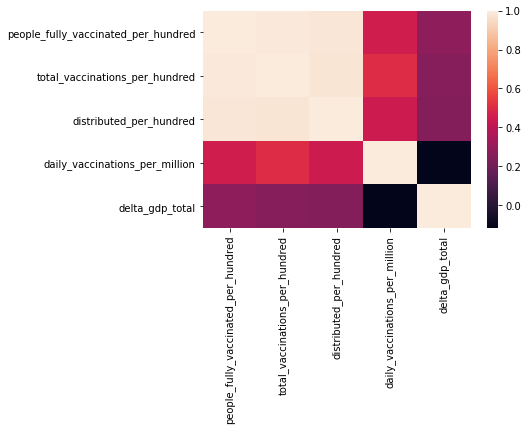

In [280]:
sns.heatmap(summarized_total.corr())

# Try to look for higher correlations for different values of "Description"

All industry total


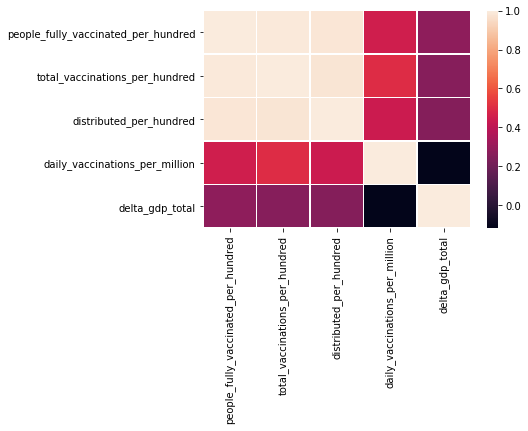

 Private industries


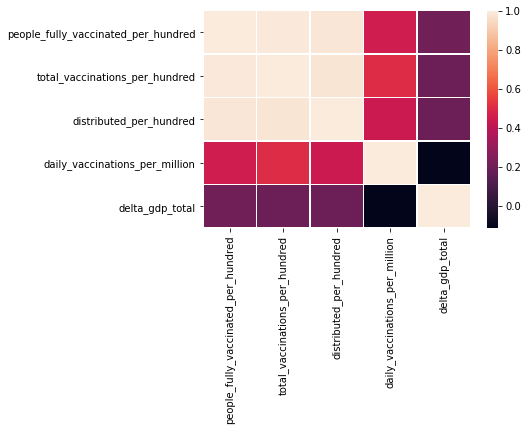

   Agriculture, forestry, fishing and hunting


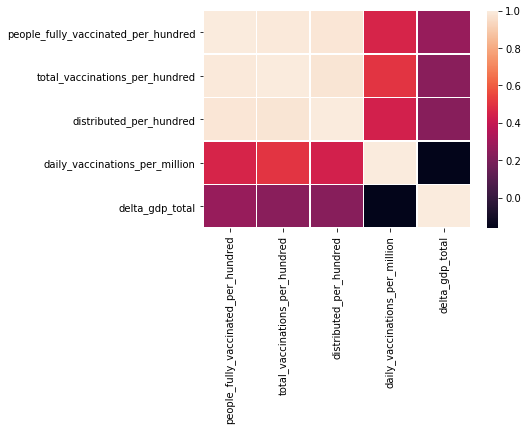

   Mining, quarrying, and oil and gas extraction


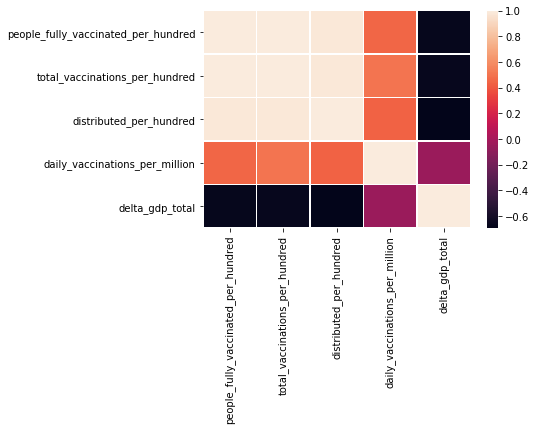

   Utilities


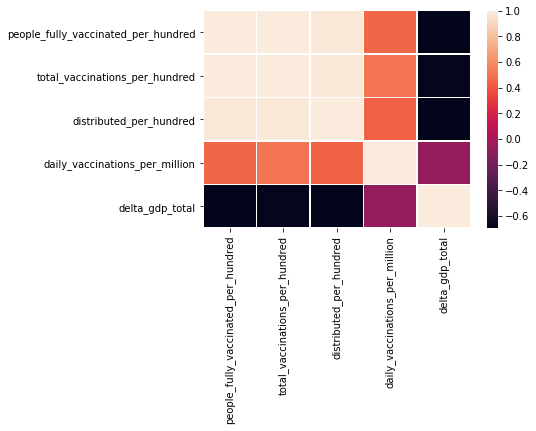

   Construction


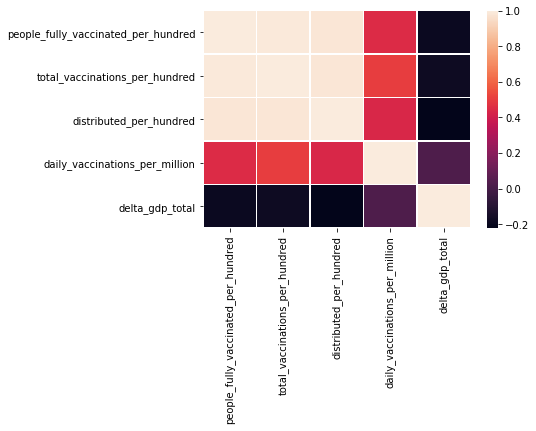

   Manufacturing


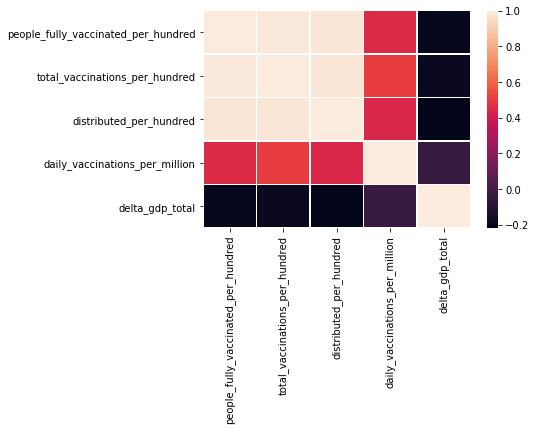

     Durable goods manufacturing


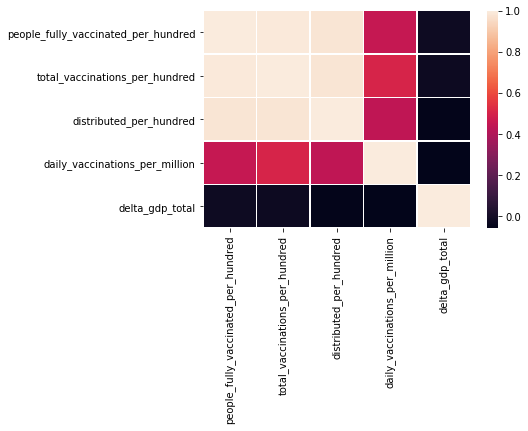

     Nondurable goods manufacturing


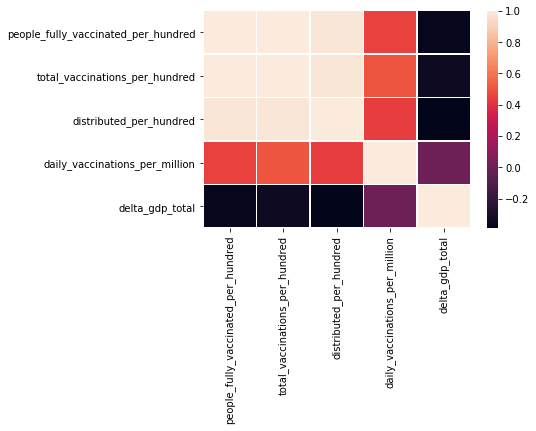

   Wholesale trade


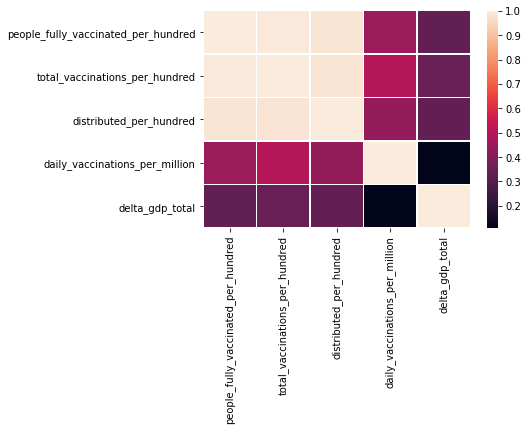

   Retail trade


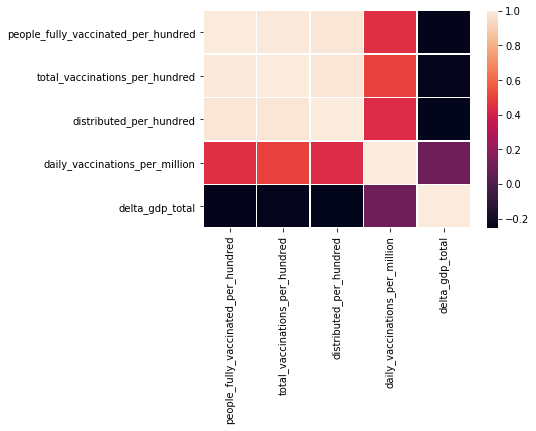

   Transportation and warehousing


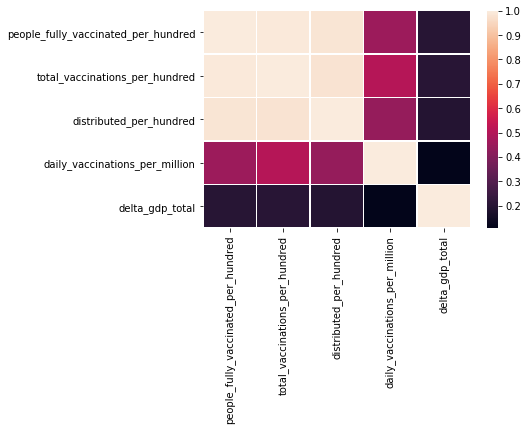

   Information


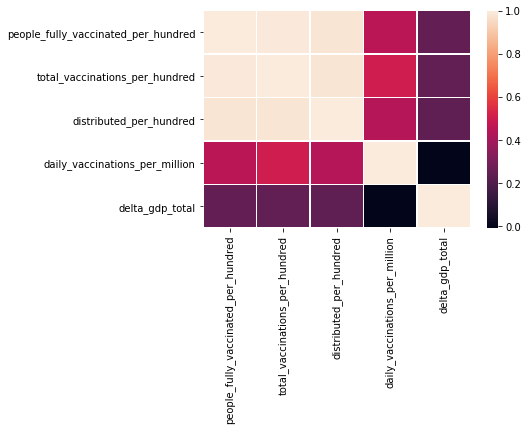

   Finance and insurance


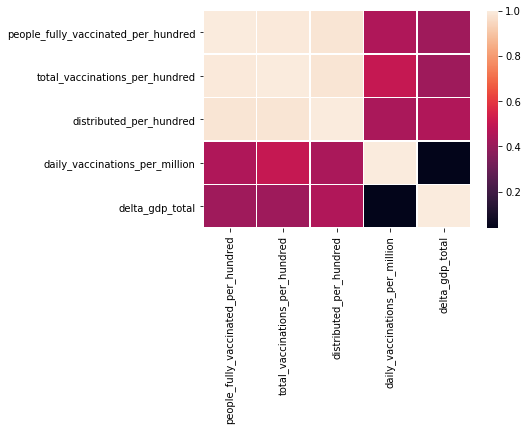

   Real estate and rental and leasing


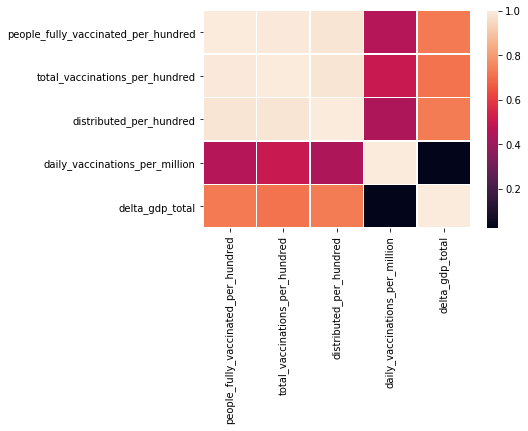

   Professional, scientific, and technical services


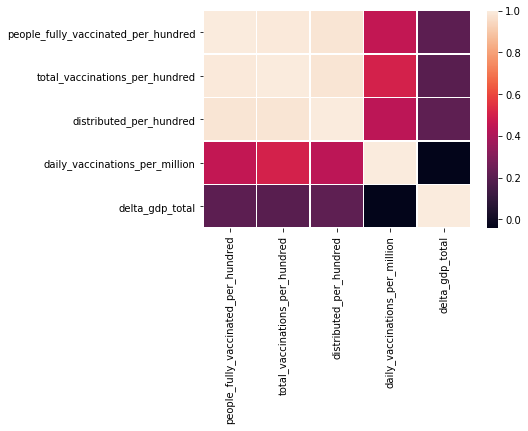

   Management of companies and enterprises


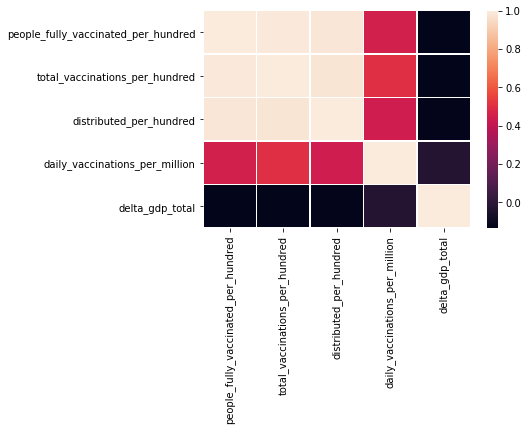

   Administrative and support and waste management and remediation services


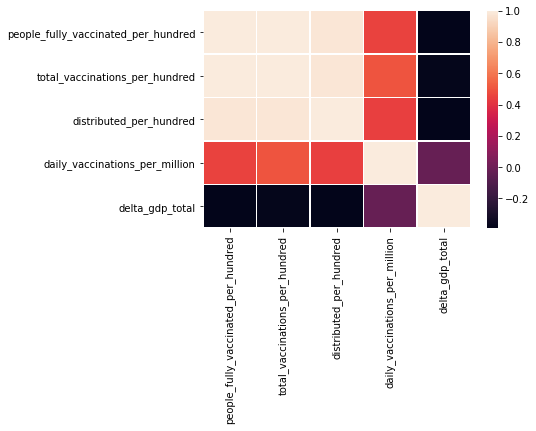

   Educational services


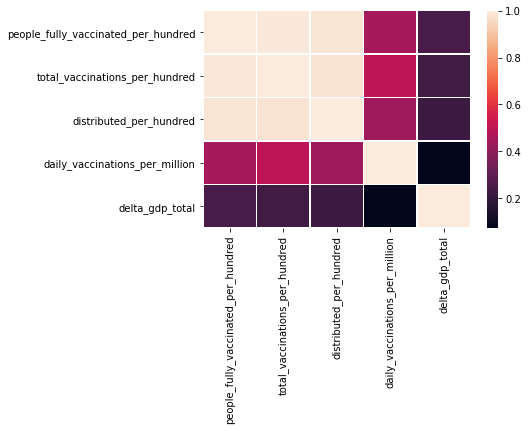

   Health care and social assistance


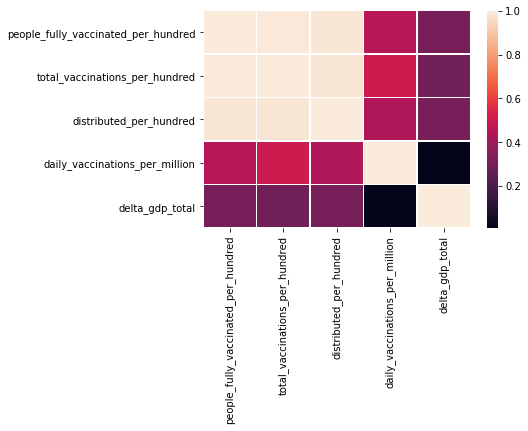

   Arts, entertainment, and recreation


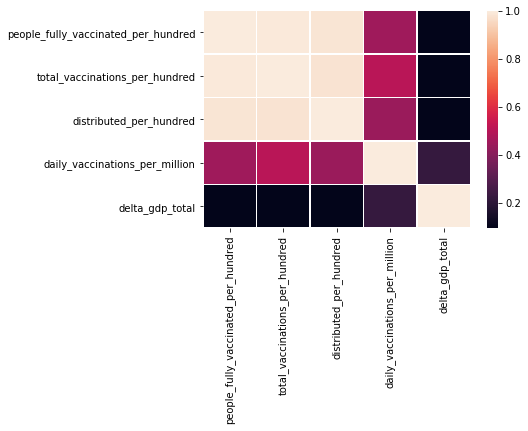

   Accommodation and food services


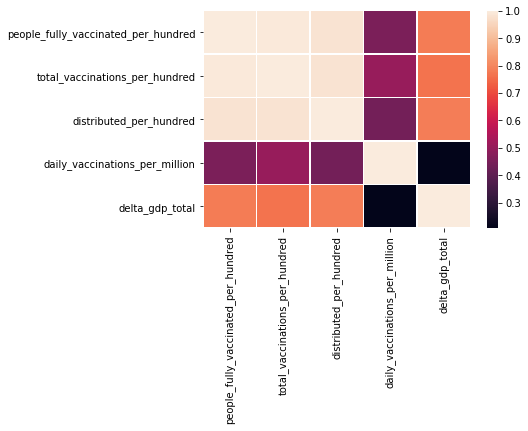

   Other services (except government and government enterprises)


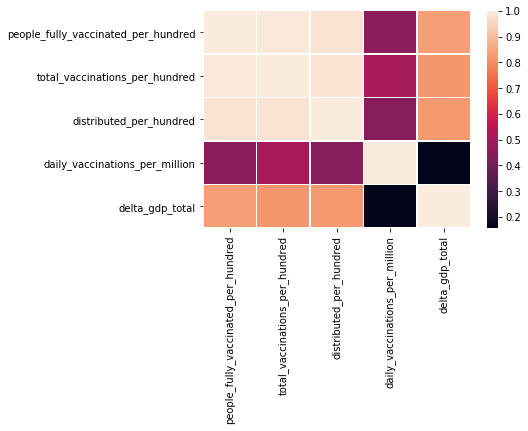

 Government and government enterprises


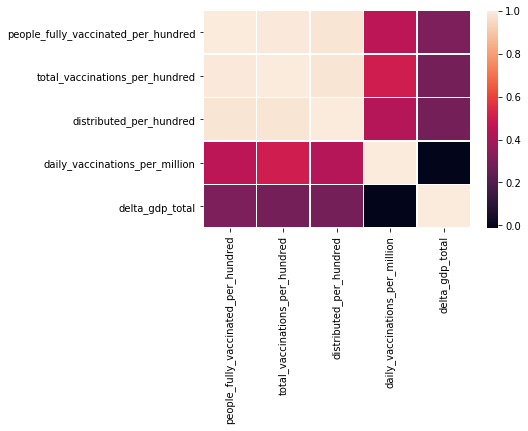

  Federal civilian


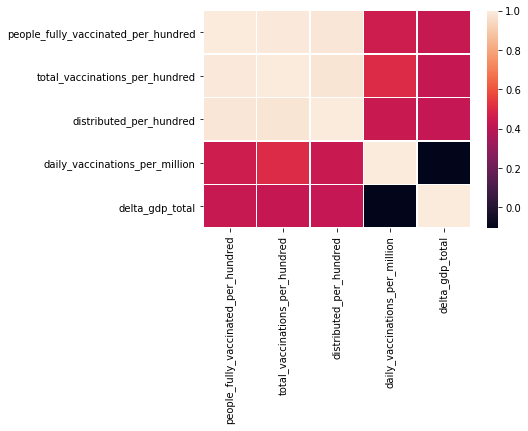

  Military


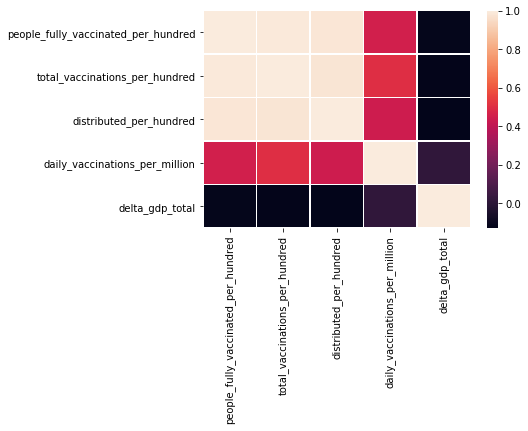

  State and local


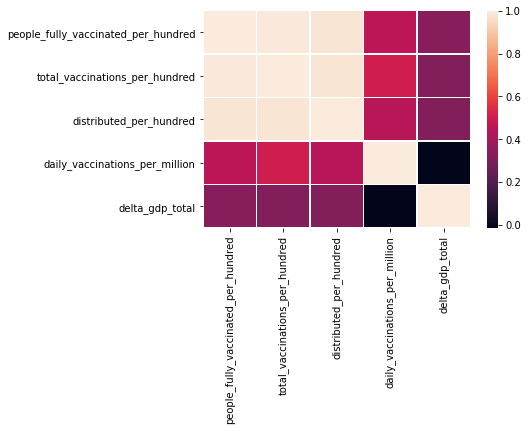

In [293]:
for description_value in gdp_df['Description'].unique():
    gdp_df_total = gdp_df[gdp_df['Description'] == description_value].drop(['2020:Q3','2020:Q2','2020:Q1','Description'], axis=1)
    gdp_df_total.replace('(D)',None,inplace=True)
    delta_2021_Q1 = gdp_df_total['2021:Q1'].astype(float)/gdp_df_total['2020:Q4'].astype(float)
    delta_2021_Q2 = gdp_df_total['2021:Q2'].astype(float)/gdp_df_total['2021:Q1'].astype(float)
    summarized_gdp_total = pd.DataFrame(columns=['quarter','location','delta_gdp_total'])
    summarized_gdp_total['delta_gdp_total'] = pd.concat([delta_2021_Q1,delta_2021_Q2])
    summarized_gdp_total['location'] = pd.concat([gdp_df_total['location'],gdp_df_total['location']])
    summarized_gdp_total.reset_index(drop=True, inplace=True)
    summarized_gdp_total['quarter'] = pd.concat([pd.Series(['2021:Q1']*50),pd.Series(['2021:Q2']*50)]).to_list()
    summarized_total = summarized_vax_quarterly.merge(summarized_gdp_total, on=['location','quarter'])
    
    print(description_value)
    ax = sns.heatmap(summarized_total.corr(), linewidth=0.5)
    plt.show()